In [ ]:
import re
import os

#Opens a file in read mode  

count = 0;  
   
vocab = {}
ct = 0
file = open("dictnostops.txt", "r")
for line in file:
    words = line.split(" ")
    for i in words:
        if len(i) > 3:
            i = i.lower()
            i = re.sub(r'[^a-z]', '', i)
            vocab[i] = ct
            ct += 1
dict_len = ct
file.close()
print("Size of dictionary: " + str(dict_len))
print(vocab)


directory = "books"

book = []
page_length = 0
ct = 0
page = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        file = open(f, "r")    

    #Gets each line till end of file is reached  
    for line in file:  
        #Splits each line into words  
        words = line.split(" ");  
        for i in words:
            i = i.lower()
            i = re.sub(r'[^a-z]', '', i)
            if len(i) != 0:
                page_length += 1
                if i in vocab:
                    if page_length < 1000:
                        page.append(i)
                    else:
                        book.append(page)
                        page = []
                        page_length = 0

    book.append(page)

count = 0
for page in book:
    count += len(page)

print("Number of words present in given file: " + str(count))
file.close();  
print(book[0])
print(len(book))

In [1]:
import xml.etree.ElementTree as ET

# Specify the limit on the number of articles to parse
articles_limit = 1

# Parse the XML dump file
tree = ET.parse('enwiki/enwiki-latest-abstract.xml')
root = tree.getroot()

# Extract relevant information (e.g., title and text)
documents = []
for idx, page in enumerate(root.iter('page')):
    title = page.find('title').text
    text = page.find('revision/text').text
    documents.append((title, text))

    print(len(documents))

    # Break out of the loop when the desired number of articles is reached
    if len(documents) == articles_limit:
        break

# Now, documents contains information from the specified number of articles

In [3]:
import numpy as np
from scipy.special import gammaln, psi

np.random.seed(100000001)
meanchangethresh = 0.001

def dirichlet_expectation(alpha):
    """
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    """
    if (len(alpha.shape) == 1):
        return(psi(alpha) - psi(np.sum(alpha)))
    return(psi(alpha) - psi(np.sum(alpha, 1))[:, np.newaxis])

In [4]:
import string

def parse_doc_list(docs, vocab):
    """
    Parse a document into a list of word ids and a list of counts,
    or parse a set of documents into two lists of lists of word ids
    and counts.

    Arguments: 
    docs:  List of D documents. Each document must be represented as
           a single string. (Word order is unimportant.) Any
           words not in the vocabulary will be ignored.
    vocab: Dictionary mapping from words to integer ids.

    Returns a pair of lists of lists. 

    The first, wordids, says what vocabulary tokens are present in
    each document. wordids[i][j] gives the jth unique token present in
    document i. (Don't count on these tokens being in any particular
    order.)

    The second, wordcts, says how many times each vocabulary token is
    present. wordcts[i][j] is the number of times that the token given
    by wordids[i][j] appears in document i.
    """
    #we will use docs as a selection of pages
    
    if (type(docs).__name__ == 'str'):
        temp = list()
        temp.append(docs)
        docs = temp

    D = len(docs)
    
    wordids = list()
    wordcts = list()
    for d in range(0, D):
        words = docs[d]
        ddict = dict()
        for word in words:
            if (word in vocab):
                wordtoken = vocab[word]
                if (not wordtoken in ddict):
                    ddict[wordtoken] = 0
                ddict[wordtoken] += 1
        wordids.append(ddict.keys())
        wordcts.append(ddict.values())

    return((wordids, wordcts))

In [5]:
import numpy as np

def do_e_step(wordids, wordcts, lambda_, expElogbeta, alpha, K):
        batchD = len(wordids)

        # Initialize the variational distribution q(theta|gamma) for
        # the mini-batch
        gamma = 1*np.random.gamma(100., 1./100., (batchD, K))
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = np.exp(Elogtheta)

        sstats = np.zeros(lambda_.shape)
        # Now, for each document d update that document's gamma and phi
        it = 0
        meanchange = 0
        for d in range(0, batchD):
            #print(sum(wordcts[d]))
            # These are mostly just shorthand (but might help cache locality)
            ids = np.array(list(wordids[d]))
            cts = np.array(list(wordcts[d]))

            gammad = gamma[d, :]
            Elogthetad = Elogtheta[d, :]
            expElogthetad = expElogtheta[d, :]
            expElogbetad = expElogbeta[:, ids]
            
            # The optimal phi_{dwk} is proportional to 
            # expElogthetad_k * expElogbetad_w. phinorm is the normalizer.
            phinorm = np.dot(expElogthetad, expElogbetad) + 1e-100
            # Iterate between gamma and phi until convergence
            for it in range(0, 100):
                lastgamma = gammad
                # We represent phi implicitly to save memory and time.
                # Substituting the value of the optimal phi back into
                # the update for gamma gives this update. Cf. Lee&Seung 2001.
                gammad = alpha + expElogthetad * \
                    np.dot(cts / phinorm, expElogbetad.T)
                #print gammad[:, n.newaxis]
                Elogthetad = dirichlet_expectation(gammad)
                expElogthetad = np.exp(Elogthetad)
                phinorm = np.dot(expElogthetad, expElogbetad) + 1e-100
                # If gamma hasn't changed much, we're done.
                meanchange = np.mean(abs(gammad - lastgamma))
                if (meanchange < meanchangethresh):
                    break
            gamma[d, :] = gammad
            # Contribution of document d to the expected sufficient
            # statistics for the M step.
            
            sstats[:, ids] += np.outer(expElogthetad.T, cts/phinorm)

        # This step finishes computing the sufficient statistics for the
        # M step, so that
        # sstats[k, w] = \sum_d n_{dw} * phi_{dwk} 
        # = \sum_d n_{dw} * exp{Elogtheta_{dk} + Elogbeta_{kw}} / phinorm_{dw}.
        sstats = sstats * expElogbeta

        return((gamma, sstats))

In [6]:
def do_e_step_docs(docs, vocab, lambda_, expElogbeta, alpha, K):
       """
       Given a mini-batch of documents, estimates the parameters
       gamma controlling the variational distribution over the topic
       weights for each document in the mini-batch.

       Arguments:
       docs:  List of D documents. Each document must be represented
              as a string. (Word order is unimportant.) Any
              words not in the vocabulary will be ignored.

       Returns a tuple containing the estimated values of gamma,
       as well as sufficient statistics needed to update lambda.
       """
       # This is to handle the case where someone just hands us a single
       # document, not in a list.

       (wordids, wordcts) = parse_doc_list(docs, vocab)

       return do_e_step(wordids, wordcts, lambda_, expElogbeta, alpha, K)

In [7]:
def approx_bound(wordids, wordcts, gamma, vocab, Elogbeta, alpha, K, D, eta, W, lambda_):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.

        batchD = len(wordids)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = np.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = np.array(list(wordids[d]))
            cts = np.array(list(wordcts[d]))
            phinorm = np.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = np.log(sum(np.exp(temp - tmax))) + tmax
            score += np.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             print oldphinorm
#             print n.log(phinorm)
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += np.sum((alpha - gamma)*Elogtheta)
        score += np.sum(gammaln(gamma) - gammaln(alpha))
        score += sum(gammaln(alpha*K) - gammaln(np.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * D / len(wordids)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + np.sum((eta-lambda_)*Elogbeta)
        score = score + np.sum(gammaln(lambda_) - gammaln(eta))
        score = score + np.sum(gammaln(eta*W) - 
                              gammaln(np.sum(lambda_, 1)))

        return(score)

In [8]:
def approx_bound_docs(docs, gamma, vocab, Elogbeta, alpha, K, D, eta, W, lambda_):
        """
        Estimates the variational bound over *all documents* using only
        the documents passed in as "docs." gamma is the set of parameters
        to the variational distribution q(theta) corresponding to the
        set of documents passed in.

        The output of this function is going to be noisy, but can be
        useful for assessing convergence.
        """

        # This is to handle the case where someone just hands us a single
        # document, not in a list.

        (wordids, wordcts) = parse_doc_list(docs, vocab)
        batchD = len(docs)

        score = 0
        Elogtheta = dirichlet_expectation(gamma)
        expElogtheta = np.exp(Elogtheta)

        # E[log p(docs | theta, beta)]
        for d in range(0, batchD):
            gammad = gamma[d, :]
            ids = np.array(list(wordids[d]))
            cts = np.array(list(wordcts[d]))
            phinorm = np.zeros(len(ids))
            for i in range(0, len(ids)):
                temp = Elogtheta[d, :] + Elogbeta[:, ids[i]]
                tmax = max(temp)
                phinorm[i] = np.log(sum(np.exp(temp - tmax))) + tmax
            score += np.sum(cts * phinorm)
#             oldphinorm = phinorm
#             phinorm = n.dot(expElogtheta[d, :], self._expElogbeta[:, ids])
#             print oldphinorm
#             print n.log(phinorm)
#             score += n.sum(cts * n.log(phinorm))

        # E[log p(theta | alpha) - log q(theta | gamma)]
        score += np.sum((alpha - gamma)*Elogtheta)
        score += np.sum(gammaln(gamma) - gammaln(alpha))
        score += sum(gammaln(alpha*K) - gammaln(np.sum(gamma, 1)))

        # Compensate for the subsampling of the population of documents
        score = score * D / len(docs)

        # E[log p(beta | eta) - log q (beta | lambda)]
        score = score + np.sum((eta-lambda_)*Elogbeta)
        score = score + np.sum(gammaln(lambda_) - gammaln(eta))
        score = score + np.sum(gammaln(eta*W) - 
                              gammaln(np.sum(lambda_, 1)))

        return(score)

In [9]:
def update_lambda(wordids, wordcts, tau0, updatect, kappa, lambda_, expElogbeta, alpha, K, Elogbeta, D, eta, W):
        """
        First does an E step on the mini-batch given in wordids and
        wordcts, then uses the result of that E step to update the
        variational parameter matrix lambda.

        Arguments:
        docs:  List of D documents. Each document must be represented
               as a string. (Word order is unimportant.) Any
               words not in the vocabulary will be ignored.

        Returns gamma, the parameters to the variational distribution
        over the topic weights theta for the documents analyzed in this
        update.

        Also returns an estimate of the variational bound for the
        entire corpus for the OLD setting of lambda based on the
        documents passed in. This can be used as a (possibly very
        noisy) estimate of held-out likelihood.
        """

        # rhot will be between 0 and 1, and says how much to weight
        # the information we got from this mini-batch.
        rhot = pow(tau0 + updatect, -kappa)

        # Do an E step to update gamma, phi | lambda for this
        # mini-batch. This also returns the information about phi that
        # we need to update lambda.
        (gamma, sstats) = do_e_step(wordids, wordcts, lambda_, expElogbeta, alpha, K)
        # Estimate held-out likelihood for current values of lambda.
        bound = approx_bound(wordids, wordcts, gamma, vocab, Elogbeta, alpha, K, D, eta, W, lambda_)
        # Update lambda based on documents.
        lambda_ = lambda_ * (1-rhot) + \
            rhot * (eta + D * sstats / len(wordids))
        Elogbeta = dirichlet_expectation(lambda_)
        expElogbeta = np.exp(Elogbeta)
        updatect += 1

        return(gamma, bound, rhot, lambda_, Elogbeta, expElogbeta, updatect)

Notes:
Digamma function = first derivative of log Gamma function
$$
\Psi(z) = \frac{\Gamma'(z)}{\Gamma(z)} \sim \text{ln}z - \frac{1}{2z}
$$

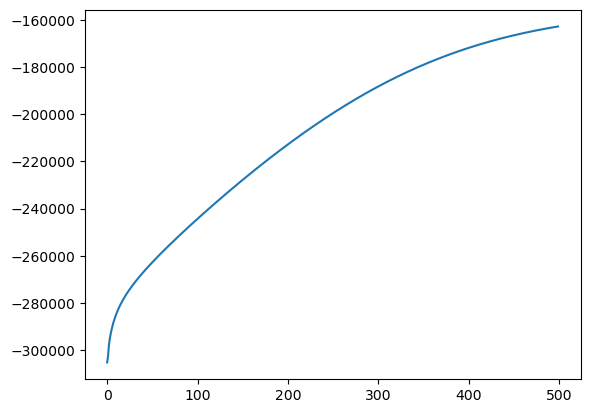

'\nfor i in range(N):\n    page = book[np.random.randint(0, len(book))]\n    g = np.ones(K)\n    phi = np.zeros((N,K))\n    for j in range(200):\n        n = 0\n        for word in np.random.choice(page, N, replace=False):\n            phi[n] = np.exp(1)\n            #print(phi)\n            n += 1\n'

In [10]:
import numpy as np
import scipy
from scipy.special import gammaln, psi

np.random.seed(1)

topic = np.random.choice(list(vocab.keys()), 20, replace=False)


K = len(topic)
W = dict_len
D = len(topic)
alpha = 1/K
eta = 1/K
tau = 1024 #just some number
kappa = 0.7 #p
updatect = 0

lambda_ = 1*np.random.gamma(100., 1./100., (K, W))
Elogbeta = dirichlet_expectation(lambda_)
expElogbeta = np.exp(Elogbeta)

beta = np.random.dirichlet(np.repeat(1/K,K), K)
theta = np.random.dirichlet(np.repeat(1/K,K), K)

N = 20

rhot = pow(tau + updatect, -kappa)
(wordids, wordcts) = parse_doc_list(book, vocab)
val = []

for i in range(500):
    (gamma, bound, rhot, lambda_, Elogbeta, expElogbeta, updatect) = update_lambda(wordids, wordcts, tau, updatect, kappa, lambda_, expElogbeta, alpha, K, Elogbeta, D, eta, W)
    score = approx_bound_docs(book, gamma, vocab, Elogbeta, alpha, K, D, eta, W, lambda_)
    val.append(score)

import matplotlib.pyplot as plt
plt.plot(val)
plt.show()

"""
for i in range(N):
    page = book[np.random.randint(0, len(book))]
    g = np.ones(K)
    phi = np.zeros((N,K))
    for j in range(200):
        n = 0
        for word in np.random.choice(page, N, replace=False):
            phi[n] = np.exp(1)
            #print(phi)
            n += 1
"""


In [11]:
def print_topic(vocab, lambda_):
    """
    Displays topics fit by onlineldavb.py. The first column gives the
    (expected) most prominent words in the topics, the second column
    gives their (expected) relative prominence.
    """

    flipped_vocab = dict([(value, key) for key, value in vocab.items()])

    for k in range(0, len(lambda_)):
        lambdak = list(lambda_[k, :])
        lambdak = lambdak / sum(lambdak)
        temp = zip(lambdak, range(0, len(lambdak)))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        print('topic %d:' % (k))
        # feel free to change the "53" here to whatever fits your screen nicely.
        for i in range(min(10, len(lambdak))):
            word_index = temp[i][1]
            word_probability = temp[i][0]
            
            # Using get to handle potential KeyError if word_index is not in vocab
            word = flipped_vocab[word_index]
            
            print(f'{word:20}  \t---\t  {word_probability:.4f}')
        print(np.size(temp))

In [12]:
print(print(vocab.items), lambda_.shape)
print_topic(vocab, lambda_)

<built-in method items of dict object at 0x000001DC512C6000>
None (20, 3978)
topic 0:
elizabeth             	---	  0.0004
said                  	---	  0.0003
believe               	---	  0.0003
mrs                   	---	  0.0003
sister                	---	  0.0003
january               	---	  0.0003
know                  	---	  0.0003
think                 	---	  0.0003
little                	---	  0.0003
inclined              	---	  0.0003
7956
topic 1:
elizabeth             	---	  0.0147
said                  	---	  0.0099
mrs                   	---	  0.0087
jane                  	---	  0.0066
know                  	---	  0.0059
think                 	---	  0.0054
soon                  	---	  0.0053
time                  	---	  0.0049
little                	---	  0.0047
lady                  	---	  0.0046
7956
topic 2:
elizabeth             	---	  0.0003
remarkably            	---	  0.0003
first                 	---	  0.0003
advantage             	---	  0.0003
suppose               